В цій практичній роботі ми спробуємо реалізувати нейронну мережу з двох шарів (прихований і вихідний). Запропонований підхід стане заготовкою для реалізації наступних оптимізацій: MBGD, ADAM та регуляризації. 

Сьогодні ж вам пропонується додати до цього класу підтримку довільної кількості шарів та нейронів в них (наприклад, передавати їх параметром в конструктор, як це робиться в MLPClassifier за допомогою hidden_layer_sizes). Також потрібно передбачити можливість ранньої зупинки ітераційного процесу, якщо значення штрафної функції не покращуватиметься протягом певної кількості ітерацій. Наприклад, якщо протягом $k$ ітерацій штрафна функція за модулем не стане меншою, ніж на поточному кроці.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score

import sklearn.linear_model

In [2]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))

    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))
    if ax is None:
        ax = plt.gca()
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

In [3]:
def plot_data(X, y):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=(y == 1), cmap=cm_bright)

In [4]:
class NeuralNet:
    
    def __init__(self, layers_sizes, normalize = True, learning_rate = 0.01, num_iter = 15000, costs_iters=300, tol=1e-7):
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
        self.layers_sizes = layers_sizes
        self.tol = tol
        self.layers = len(layers_sizes) + 1
        print("Layers: {}".format(self.layers))
        self.costs_iters = costs_iters
    
    def __normalize(self, X, mean = None, std = None):
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s
        return X_new, m, s

    def __sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
    
    def __sigmoid_derivative(self, A):
        return np.multiply(A, 1 - A)
    
    def __initialize_parameters(self):
        W, b = [], []
        
        for l in range(1,self.layers+1):
            W_l = np.random.randn(self.layers_sizes[l], self.layers_sizes[l-1]) * 0.01
            b_l = np.zeros((self.layers_sizes[l], 1))
            W.append(W_l)
            b.append(b_l)
        
        self.parameters = {"W" : W, "b" : b}
        
        for key in self.parameters:
            for key_i,i in zip(self.parameters[key],range(len(self.parameters[key]))):
                print("{}{}: {}".format(key,i+1,key_i.shape))
       
    def __forward_propagation(self, X):            
        W = self.parameters["W"]
        b = self.parameters["b"]
        Z, A = [], [] 

        A.append(X)
        for l in range(0,self.layers):
            Z_l = np.dot(W[l],A[l]) + b[l]
            A_l = self.__sigmoid(Z_l)
            Z.append(Z_l)
            A.append(A_l)
        
        cache = (Z,A)
        return A[-1], cache
    
    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        return J
    
    def __backward_propagation(self, X, Y, cache):
        m = X.shape[1]
        
        W = self.parameters["W"]
        b = self.parameters["b"]
        (Z,A) = cache
        
        dZ, dW, db = [], [], []
        
        dZ_l = A[-1] - Y
        dW_l = 1. / m * np.dot(dZ_l, A[-2].T)
        db_l = 1. / m * np.sum(dZ_l, axis = 1, keepdims = True)
        
        dZ.insert(0,dZ_l)
        dW.insert(0,dW_l)
        db.insert(0,db_l)
        
        for l in range(self.layers-1,0,-1):
            dA_l = np.dot(W[l].T,dZ_l)
            dZ_l = np.multiply(dA_l, self.__sigmoid_derivative(A[l]))
            dW_l = 1. / m * np.dot(dZ_l, A[l-1].T)
            db_l = 1. / m * np.sum(dZ_l, axis = 1, keepdims = True)
            dZ.insert(0,dZ_l)
            dW.insert(0,dW_l)
            db.insert(0,db_l)
        
        grads = {"dZ":dZ,"dW":dW,"db":db}
        return grads
  
    
    def __update_parameters(self, grads):        
        W = self.parameters["W"]
        b = self.parameters["b"]
        dW = grads["dW"]
        db = grads["db"]
    
        for l in range(0,len(W)):
            W[l] = W[l] - self.learning_rate * dW[l]
            b[l] = b[l] - self.learning_rate * db[l]
            
        self.parameters["W"] = W
        self.parameters["b"] = b

        
    def fit(self, X_vert, Y_vert, print_cost = True):
        
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        costs_imp = []
        
        m = X.shape[1]
        n_x = X.shape[0]
        
        self.layers_sizes.insert(0,n_x)
        self.layers_sizes.append(1);
        
        self.__initialize_parameters()

        for i in range(self.num_iter):
            A, cache = self.__forward_propagation(X)

            cost = self.compute_cost(A, Y)
            
            grads = self.__backward_propagation(X, Y, cache)

            self.__update_parameters(grads)

            if print_cost and i % 1000 == 0:
                print("{}-th iteration: {}".format(i, cost))

            if i % 1000 == 0:
                costs.append(cost)
            
            costs_imp.append(cost)
            if i > self.costs_iters:
                len_imp = len(costs_imp)-1
                if abs(costs_imp[len_imp] - costs_imp[len_imp-self.costs_iters]) < self.tol:
                    print("Stop iteration: {}".format(i))
                    break;

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *1000")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        
        return np.column_stack((probs.T, 1 - probs.T))
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)[:, 0]
        return (positive_probs >= 0.5).astype(int)   


Спочатку спробуйте цей клас на одній задачі, а потім на іншій.

# Dataset 1

In [5]:
data_columns = ["exam1", "exam2"]
target_column = "submitted"
df = pd.read_csv("sats.csv")
X, Y = df[data_columns].values, df[target_column].values.reshape((df.shape[0], 1))
print('Training set: X={}, y={}'.format(X.shape, Y.shape))

Training set: X=(100, 2), y=(100, 1)


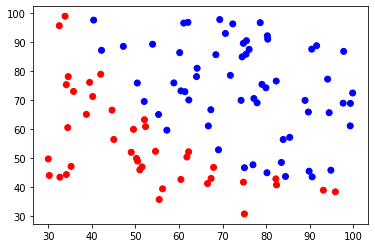

In [6]:
plot_data(X, Y)

In [7]:
cls = NeuralNet(layers_sizes = [5,5], normalize = True, learning_rate = 0.1, num_iter = 12001, tol = 1e-7, costs_iters=500)

Layers: 3


W1: (5, 2)
W2: (5, 5)
W3: (1, 5)
b1: (5, 1)
b2: (5, 1)
b3: (1, 1)
0-th iteration: 0.6929428819445586
1000-th iteration: 0.6730047345089705
2000-th iteration: 0.6729920976791126
3000-th iteration: 0.6729567564260499
4000-th iteration: 0.6728400884462642
5000-th iteration: 0.6722744479443817
6000-th iteration: 0.6637905725761861
7000-th iteration: 0.2812008292150347
8000-th iteration: 0.2240302220116947
9000-th iteration: 0.2060278681574579
10000-th iteration: 0.16803827042990813
11000-th iteration: 0.12624715827406058
12000-th iteration: 0.09533289703486986


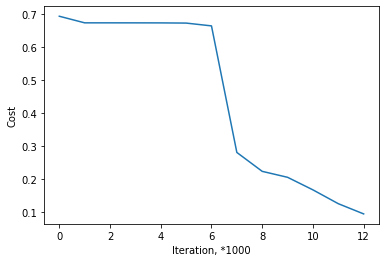

In [8]:
cls.fit(X, Y)

In [9]:
for key in cls.parameters:
    print("{}:\n".format(key))
    for i in cls.parameters[key]:
        print("{}\n".format(i))

W:

[[-1.13937418 -1.26320795]
 [ 3.44550618  0.41950804]
 [-0.61750559 -2.0034776 ]
 [-0.22228436 -2.46769041]
 [ 2.03888672  0.84374202]]

[[-0.89637658  1.31363927 -1.02306209 -1.15570693  0.75542359]
 [-1.12094734  1.86068762 -1.25307764 -1.53911139  0.99538025]
 [-1.36672637  2.605693   -1.61455592 -2.05318014  1.28551329]
 [-0.85323876  1.22212464 -0.95481138 -1.11280938  0.72396145]
 [-1.58638259  3.14560975 -1.8695006  -2.42164546  1.51062689]]

[[1.56989787 2.50215599 3.89248501 1.41852557 4.8865297 ]]

b:

[[-0.15441033]
 [ 2.94549695]
 [-1.08723613]
 [-2.21005683]
 [ 0.88253002]]

[[-0.41891333]
 [-0.46964273]
 [-0.58859367]
 [-0.42122287]
 [-0.68638835]]

[[-6.05903184]]



In [10]:
Y_prob = cls.predict_proba(X)
Y_prob

array([[3.47339293e-02, 9.65266071e-01],
       [2.96060324e-03, 9.97039397e-01],
       [2.12612737e-02, 9.78738726e-01],
       [9.98460702e-01, 1.53929754e-03],
       [9.98968035e-01, 1.03196505e-03],
       [7.94416277e-03, 9.92055837e-01],
       [9.98958855e-01, 1.04114500e-03],
       [4.90616729e-01, 5.09383271e-01],
       [9.99158903e-01, 8.41097095e-04],
       [6.24957669e-01, 3.75042331e-01],
       [5.49576404e-01, 4.50423596e-01],
       [1.79172214e-02, 9.82082779e-01],
       [9.99063449e-01, 9.36551203e-04],
       [9.99177577e-01, 8.22423058e-04],
       [6.87168589e-02, 9.31283141e-01],
       [9.97124264e-01, 2.87573599e-03],
       [8.00413852e-01, 1.99586148e-01],
       [1.58515842e-01, 8.41484158e-01],
       [9.99150791e-01, 8.49209037e-04],
       [7.03889088e-01, 2.96110912e-01],
       [4.61809254e-02, 9.53819075e-01],
       [9.98783014e-01, 1.21698646e-03],
       [6.70295445e-03, 9.93297046e-01],
       [3.02653100e-03, 9.96973469e-01],
       [9.985449

In [11]:
Y_hat = cls.predict(X)
Y_hat

array([0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1])

In [12]:
accuracy_score(Y, Y_hat)

0.97

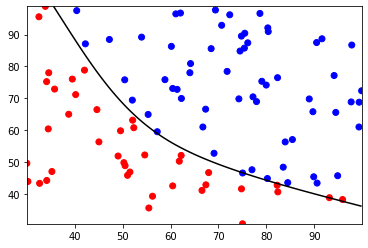

In [13]:
plot_data(X, Y)
plot_surface(cls, X[:, 0], X[:, 1])

# Dataset 2

In [14]:
data_columns = ["test1", "test2"]
target_column = "passed"
df = pd.read_csv("tests.csv")
X2, Y2 = df[data_columns].values, df[target_column].values.reshape((df.shape[0], 1))
print('Training set: X={}, y={}'.format(X2.shape, Y2.shape))

Training set: X=(118, 2), y=(118, 1)


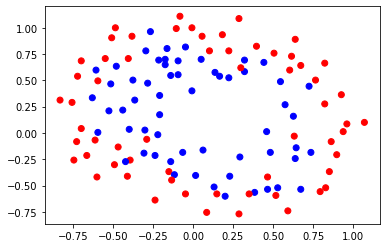

In [15]:
plot_data(X2, Y2)

In [16]:
cls2 = NeuralNet(layers_sizes = [70,60], normalize = True, learning_rate = 0.5, num_iter = 20001, tol = 1e-7, costs_iters=500)

Layers: 3


W1: (70, 2)
W2: (60, 70)
W3: (1, 60)
b1: (70, 1)
b2: (60, 1)
b3: (1, 1)
0-th iteration: 0.6932406193569514
1000-th iteration: 0.6930034855527166
2000-th iteration: 0.6930031519022005
3000-th iteration: 0.6930027751255101
4000-th iteration: 0.693002296228847
5000-th iteration: 0.6930016245494197
6000-th iteration: 0.6930005997078663
7000-th iteration: 0.6929989049668868
8000-th iteration: 0.6929958421899999
9000-th iteration: 0.6929896560282762
10000-th iteration: 0.6929750810611368
11000-th iteration: 0.6929317032273024
12000-th iteration: 0.692742080554977
13000-th iteration: 0.6915181957314726
14000-th iteration: 0.6907078413066136
15000-th iteration: 0.6899993773957367
16000-th iteration: 0.6845303032061439
17000-th iteration: 0.6223962696386874
18000-th iteration: 0.44103744103854375
19000-th iteration: 0.3408060856173626
20000-th iteration: 0.3189951561629075


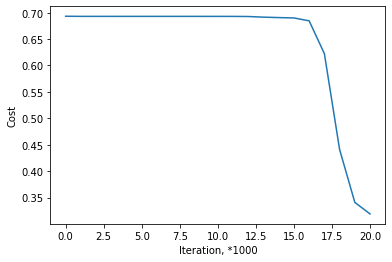

In [17]:
cls2.fit(X2, Y2)

In [18]:
for key in cls2.parameters:
    print("{}:\n".format(key))
    for i in cls2.parameters[key]:
        print("{}\n".format(i))

W:

[[-6.88598038e-01 -1.80400197e-01]
 [ 6.13626097e-01  5.79333933e-01]
 [-7.50439776e-01 -1.88771218e-01]
 [-2.69979572e-01  3.42964240e-01]
 [-9.03450753e-01 -4.89523014e-01]
 [ 7.18119371e-01  5.71362803e-01]
 [-5.70018210e-01  1.42859681e-01]
 [-7.25624247e-01  1.38291966e+00]
 [ 1.16349785e+00  6.42124830e-01]
 [ 9.69202061e-01  5.63697974e-01]
 [-1.17981639e+00 -6.98082347e-01]
 [ 8.43387742e-01  4.72298468e-01]
 [ 7.29716922e-01  5.13276869e-01]
 [-5.30804413e-01  2.89976468e-01]
 [ 8.05237523e-01  4.13546444e-01]
 [-8.27606716e-01 -2.61611101e-01]
 [ 8.68838558e-01  6.01049505e-01]
 [-6.25293524e-02  4.48172913e-01]
 [ 1.10221673e-01  6.65506084e-01]
 [-2.73622565e-01  2.88648786e-01]
 [ 6.11210201e-01  4.52617985e-01]
 [-1.35613583e-02  1.50063529e-01]
 [-6.96121206e-01 -7.61556690e-03]
 [ 3.61768974e-01  2.44943227e-01]
 [-5.68968574e-01 -3.02470646e-02]
 [ 1.00607315e+00  5.98677373e-01]
 [ 2.08398043e-01  7.07340469e-01]
 [-2.57271755e-01  6.52969121e-01]
 [ 8.65958258e-0

In [19]:
Y2_prob = cls2.predict_proba(X2)
Y2_prob

array([[0.58949399, 0.41050601],
       [0.96937634, 0.03062366],
       [0.24208879, 0.75791121],
       [0.12822942, 0.87177058],
       [0.03284712, 0.96715288],
       [0.93348923, 0.06651077],
       [0.01711953, 0.98288047],
       [0.20583714, 0.79416286],
       [0.82341366, 0.17658634],
       [0.9689111 , 0.0310889 ],
       [0.98874482, 0.01125518],
       [0.23574405, 0.76425595],
       [0.37253237, 0.62746763],
       [0.03501384, 0.96498616],
       [0.86289532, 0.13710468],
       [0.22696699, 0.77303301],
       [0.72808416, 0.27191584],
       [0.71843038, 0.28156962],
       [0.81542122, 0.18457878],
       [0.10642312, 0.89357688],
       [0.99683475, 0.00316525],
       [0.9008518 , 0.0991482 ],
       [0.88030616, 0.11969384],
       [0.02431587, 0.97568413],
       [0.26643905, 0.73356095],
       [0.79689925, 0.20310075],
       [0.12842947, 0.87157053],
       [0.31102881, 0.68897119],
       [0.45770109, 0.54229891],
       [0.8892396 , 0.1107604 ],
       [0.

In [20]:
Y2_hat = cls2.predict(X2)
Y2_hat

array([1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 0])

In [21]:
accuracy_score(Y2, Y2_hat)

0.847457627118644

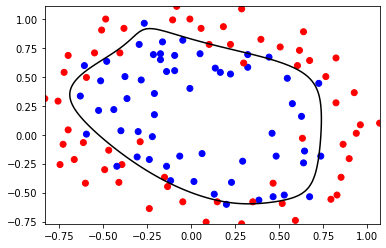

In [22]:
plot_data(X2, Y2)
plot_surface(cls2, X2[:, 0], X2[:, 1])

Зверніть увагу на границю прийняття рішення. Модель старається побудувати складну криву, що може свідчити про її перетренування. Порівняйте отримані результати з класом з sklearn. Спробуйте додати нові шари для нашого класу та порівняти результати тоді. Поекспериментуйте з гіперпараметрами для обох класів.

In [23]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (20,20), max_iter = 20001, solver = 'adam', activation = 'relu')#, solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')

In [24]:
clf.fit(X2, Y2)

D:\university\c3\ml\lectures\l2\test1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPClassifier(hidden_layer_sizes=(20, 20), max_iter=20001)

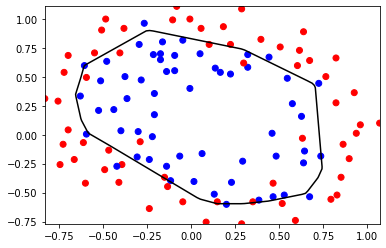

In [25]:
plot_data(X2, Y2)
plot_surface(clf, X2[:, 0], X2[:, 1])

In [26]:
accuracy_score(Y2, clf.predict(X2))

0.8559322033898306

In [27]:
clf.n_iter_

622

# Dataset 3

In [28]:
data_columns = ["test1","test2","test1test1","test2test2","test1test2","test1test1test1","test2test2test2"]
target_column = "passed"
df = pd.read_csv("testsCom.csv")
X3, Y3 = df[data_columns].values, df[target_column].values.reshape((df.shape[0], 1))
print('Training set: X={}, y={}'.format(X3.shape, Y3.shape))

Training set: X=(118, 7), y=(118, 1)


In [29]:
cls3 = NeuralNet(layers_sizes = [15,10], normalize = True, learning_rate = 0.3, num_iter = 10001, tol = 1e-7, costs_iters=500)

Layers: 3


W1: (15, 7)
W2: (10, 15)
W3: (1, 10)
b1: (15, 1)
b2: (10, 1)
b3: (1, 1)
0-th iteration: 0.6930298574274395
1000-th iteration: 0.6930032873601932
2000-th iteration: 0.6930028511403395
3000-th iteration: 0.6930021593432503
4000-th iteration: 0.6930007338506419
5000-th iteration: 0.6929969108354391
6000-th iteration: 0.692981523542723
7000-th iteration: 0.6928237265651563
8000-th iteration: 0.48660357132096904
9000-th iteration: 0.34440945359900604
10000-th iteration: 0.33081392134028603


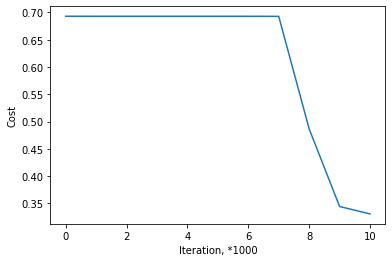

In [30]:
cls3.fit(X3, Y3)

In [31]:
for key in cls.parameters:
    print("{}:\n".format(key))
    for i in cls.parameters[key]:
        print("{}\n".format(i))

W:

[[-1.13937418 -1.26320795]
 [ 3.44550618  0.41950804]
 [-0.61750559 -2.0034776 ]
 [-0.22228436 -2.46769041]
 [ 2.03888672  0.84374202]]

[[-0.89637658  1.31363927 -1.02306209 -1.15570693  0.75542359]
 [-1.12094734  1.86068762 -1.25307764 -1.53911139  0.99538025]
 [-1.36672637  2.605693   -1.61455592 -2.05318014  1.28551329]
 [-0.85323876  1.22212464 -0.95481138 -1.11280938  0.72396145]
 [-1.58638259  3.14560975 -1.8695006  -2.42164546  1.51062689]]

[[1.56989787 2.50215599 3.89248501 1.41852557 4.8865297 ]]

b:

[[-0.15441033]
 [ 2.94549695]
 [-1.08723613]
 [-2.21005683]
 [ 0.88253002]]

[[-0.41891333]
 [-0.46964273]
 [-0.58859367]
 [-0.42122287]
 [-0.68638835]]

[[-6.05903184]]



In [37]:
Y3_prob = cls3.predict_proba(X3)
Y3_prob

array([[8.99378221e-01, 1.00621779e-01],
       [8.82384180e-01, 1.17615820e-01],
       [8.65324275e-01, 1.34675725e-01],
       [9.36145668e-01, 6.38543319e-02],
       [8.72610738e-01, 1.27389262e-01],
       [8.64707147e-01, 1.35292853e-01],
       [9.02167151e-01, 9.78328486e-02],
       [8.03946291e-01, 1.96053709e-01],
       [8.43851952e-01, 1.56148048e-01],
       [7.13725749e-01, 2.86274251e-01],
       [6.43946992e-01, 3.56053008e-01],
       [6.49761843e-01, 3.50238157e-01],
       [8.53513829e-01, 1.46486171e-01],
       [7.21014770e-01, 2.78985230e-01],
       [8.29527364e-01, 1.70472636e-01],
       [9.22024529e-01, 7.79754709e-02],
       [9.59243676e-01, 4.07563238e-02],
       [5.82106684e-01, 4.17893316e-01],
       [8.67688124e-01, 1.32311876e-01],
       [7.24611433e-01, 2.75388567e-01],
       [4.44893645e-01, 5.55106355e-01],
       [6.87089895e-01, 3.12910105e-01],
       [3.35541975e-01, 6.64458025e-01],
       [1.70351238e-01, 8.29648762e-01],
       [6.984914

In [38]:
Y3_hat = cls3.predict(X3)
Y3_hat

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1])

In [39]:
accuracy_score(Y3, Y3_hat)

0.864406779661017